# Exporting QCoDes Datasets

This notebook demonstrates how we can export QCoDeS datasets to other file formats. 

## Setup

First, we borrow an example from the measurement notebook to have some data to work with.

In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import qcodes as qc
from qcodes.dataset import initialise_or_create_database_at, load_or_create_experiment, Measurement, load_by_run_spec
from qcodes.tests.instrument_mocks import (
    DummyInstrument,
    DummyInstrumentWithMeasurement,
)
from qcodes.dataset.plotting import plot_dataset
qc.logger.start_all_logging()

Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\jenielse\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\jenielse\.qcodes\logs\211027-12584-qcodes.log


In [2]:
# preparatory mocking of physical setup
dac = DummyInstrument("dac", gates=["ch1", "ch2"])
dmm = DummyInstrumentWithMeasurement("dmm", setter_instr=dac)
station = qc.Station(dmm, dac)

In [3]:
initialise_or_create_database_at("./export_example.db")
exp = load_or_create_experiment(
    experiment_name="working_with_pandas", sample_name="no sample"
)

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]


In [4]:
meas = Measurement(exp)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dac.ch2)  # register the second independent parameter
meas.register_parameter(
    dmm.v2, setpoints=(dac.ch1, dac.ch2)
)  # register the dependent one

We then perform two very basic measurements using dummy instruments.

In [5]:
# run a 2D sweep

with meas.run() as datasaver:

    for v1 in np.linspace(-1, 0, 200, endpoint=False):
        for v2 in np.linspace(-1, 1, 201):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1), (dac.ch2, v2), (dmm.v2, val))

dataset1 = datasaver.dataset

Starting experimental run with id: 1. 


In [6]:
# run a 2D sweep

with meas.run() as datasaver:
    for v1 in np.linspace(0, 1, 200, endpoint=False):
        for v2 in np.linspace(1, 2, 201):
            dac.ch1(v1)
            dac.ch2(v2)
            val = dmm.v2.get()
            datasaver.add_result((dac.ch1, v1), (dac.ch2, v2), (dmm.v2, val))

dataset2 = datasaver.dataset

Starting experimental run with id: 2. 


## Export from comandline

The dataset can be exported using the `export` method. Currently exporting to netcdf and csv is supported.

In [7]:
dataset2.export("netcdf", path=".")

The `export_info` attribute contains information about where the dataset has been exported to:

In [9]:
dataset2.export_info

ExportInfo(export_paths={'nc': 'C:\\Users\\jenielse\\source\\repos\\Qcodes\\docs\\examples\\DataSet\\qcodes_2.nc'})

Looking at the signature of export we can see that in addition to the file format we can set the `prefix` and `path` to export to.

In [10]:
?dataset2.export

Signature:
dataset2.export(
    export_type: 'Optional[Union[DataExportType, str]]' = None,
    path: 'Optional[str]' = None,
    prefix: 'Optional[str]' = None,
) -> 'None'
Docstring:
Export data to disk with file name {prefix}{run_id}.{ext}.
Values for the export type, path and prefix can also be set in the "dataset"
section of qcodes config.

Args:
    export_type: Data export type, e.g. "netcdf" or ``DataExportType.NETCDF``,
        defaults to a value set in qcodes config
    path: Export path, defaults to value set in config
    prefix: File prefix, e.g. ``qcodes_``, defaults to value set in config.

Raises:
    ValueError: If the export data type is not specified or unknown, raise an error
File:      c:\users\jenielse\source\repos\qcodes\qcodes\dataset\data_set_protocol.py
Type:      method


## Automatic export

Datasets may also be exported automatically using the configuration options given in dataset config section. 
Here you can toggle if a dataset should be exported automatically using the `export_automatic` option as well as set the default type, prefix and path. See [the table here](https://qcodes.github.io/Qcodes/user/configuration.html) for the relevant configuration options.

For more information about how to configure QCoDeS datasets see [the page about configuration](https://qcodes.github.io/Qcodes/user/configuration.html)  in the QCoDeS docs.

## Importing exported datasets into a new database

The above dataset has been created in the following database

In [14]:
qc.config.core.db_location

'./export_example.db'

Now lets imagine that we move the exported dataset to a different computer. To emulate this we will create a new database file and set it as the active database. 

In [15]:
initialise_or_create_database_at("./reimport_example.db")

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]
Upgrading database; v1 -> v2: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.20it/s]
Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]
Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]
Upgrading database; v4 -> v5: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.99it/s]
Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]
Upgrading database; v8 -> v9: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 642.12it/s]


In [16]:
qc.config.core.db_location

'./reimport_example.db'

In [17]:
from qcodes.dataset.data_set_in_memory import DataSetInMem

In [19]:
loaded_ds = DataSetInMem.load_from_netcdf(dataset2.export_info.export_paths['nc'])

([<AxesSubplot:title={'center':'Run #2, Experiment working_with_pandas (no sample)'}, xlabel='Gate ch1 (mV)', ylabel='Gate ch2 (V)'>],
 [<matplotlib.colorbar.Colorbar at 0x1d4ab4c2b20>])

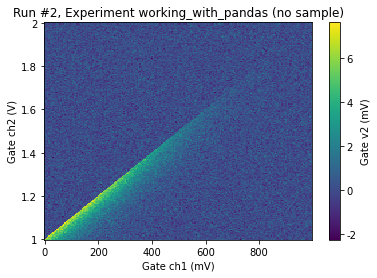

In [20]:
plot_dataset(loaded_ds)

In [24]:
captured_run_id = loaded_ds.captured_run_id
captured_run_id

2

In [22]:
loaded_ds.run_id

2

In [25]:
loaded_ds.write_metadata_to_db()

In [26]:
del loaded_ds

In [27]:
reloaded_ds = load_by_run_spec(captured_run_id=29)

NameError: No run matching the supplied information found.

([<AxesSubplot:title={'center':'Run #29, Experiment working_with_pandas (no sample)'}, xlabel='Gate ch1 (V)', ylabel='Gate ch2 (V)'>],
 [<matplotlib.colorbar.Colorbar at 0x2438d80c2b0>])

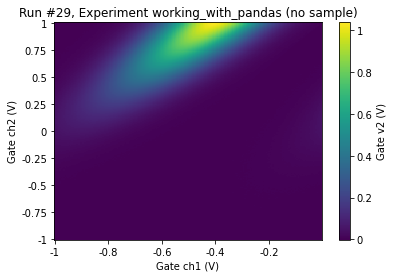

In [31]:
plot_dataset(reloaded_ds)

In [32]:
reloaded_ds.run_id

1

In [33]:
reloaded_ds.captured_run_id

29